In [32]:
from fastai.vision.all import *
import torch
from fastcore.parallel import *

import gc
def clear_gpu_cache():
    gc.collect()
    torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
set_seed(42)

cuda


**Topics to learn**
1. **Normalization**
    1. when using `Learner` you need to specify `Normalize` stats. When using `vision_learner`, fastai does it for us automatically.
2. **Progressive resizing**: start training using small images, and end training using large images. Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher. There is an additional benefit to progressive resizing: **it is another form of data augmentation**. Therefore, you should expect to see better generalization of your models that are trained with progressive resizing
3. **tta**
4. **mixup**

#### Results

In [31]:
results_df = pd.DataFrame([['Baseline','xresnet50' ,'82.65%'], ['Normalization','xresnet50' , '83.03%'], ['Normalization + Progressive Resizing','xresnet50' , '90.00%'],['Normalization + Progressive Resizing + TTA','xresnet50' , '90.38%']], columns = ['Variation', 'Architecture', 'Accuracy'])
results_df

,Variation,Architecture,Accuracy
0,Baseline,xresnet50,82.65%
1,Normalization,xresnet50,83.03%
2,Normalization + Progressive Resizing,xresnet50,90.00%
3,Normalization + Progressive Resizing + TTA,xresnet50,90.38%


In [2]:
path = Path('paddy-disease-classification')
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images')]

In [3]:
(path/'train_images').ls()

(#10) [Path('paddy-disease-classification/train_images/bacterial_leaf_blight'),Path('paddy-disease-classification/train_images/bacterial_leaf_streak'),Path('paddy-disease-classification/train_images/bacterial_panicle_blight'),Path('paddy-disease-classification/train_images/blast'),Path('paddy-disease-classification/train_images/brown_spot'),Path('paddy-disease-classification/train_images/dead_heart'),Path('paddy-disease-classification/train_images/downy_mildew'),Path('paddy-disease-classification/train_images/hispa'),Path('paddy-disease-classification/train_images/normal'),Path('paddy-disease-classification/train_images/tungro')]

In [4]:
sample_im = get_image_files((path/'train_images').ls()[0])[0]
sample_im

Path('paddy-disease-classification/train_images/bacterial_leaf_blight/100023.jpg')

In [5]:
parent_label(sample_im)

'bacterial_leaf_blight'

In [6]:
trn_path = path/'train_images'
trn_path

Path('paddy-disease-classification/train_images')

In [7]:
len(get_image_files(trn_path))

10407

In [8]:
len(get_image_files(path/'test_images')) # these don't have folder structure. They are not validation

3469

In [9]:
def f(o): return PILImage.create(o).size

# NO NEED TO RUN AGAIN.

# images = get_image_files(path)
# sizes = parallel(f, images, n_workers=8)
# pd.Series(sizes).value_counts()


size_df = pd.DataFrame([['(480, 640)', '13870'],['(640, 480)','6']], columns=['Image size', 'number'])
size_df

,Image size,number
0,"(480, 640)",13870
1,"(640, 480)",6


In [10]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  get_y = parent_label, 
                   item_tfms= Resize(460),
                  batch_tfms = aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(trn_path, bs=32)

In [11]:
dblock.summary(trn_path)

Setting-up type transforms pipelines
Found 10407 items
2 datasets of sizes 8326,2081
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      paddy-disease-classification\train_images\tungro\100337.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=480x640
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      paddy-disease-classification\train_images\tungro\100337.jpg
    applying parent_label gives
      tungro
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=480x640, TensorCategory(9))


Found 10407 items
2 datasets of sizes 8326,2081
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setti

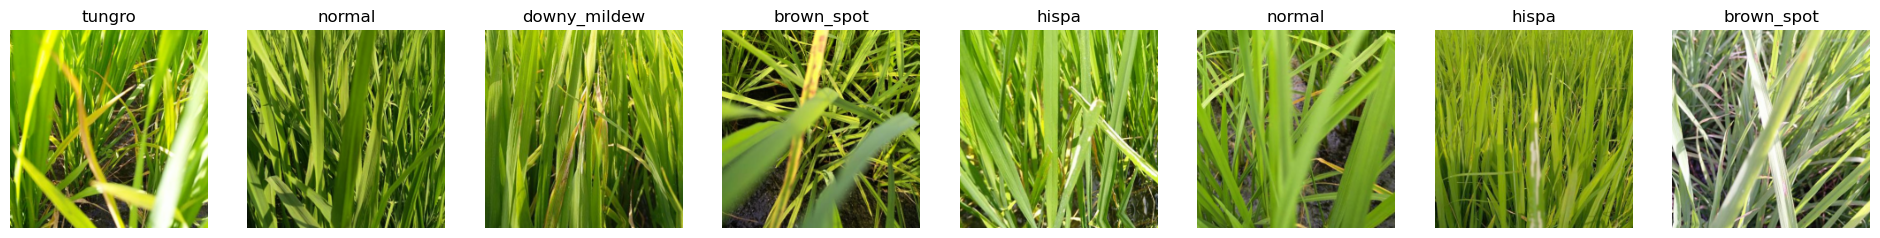

In [12]:
dls.train.show_batch(nrows=1, ncols=8)

In [13]:
dls.c  # number of classes

10

In [14]:
clear_gpu_cache()

# 1. Baseline xresnet50 (from scratch)

In [15]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.796719,3.521390,0.300336,02:03
1,1.422194,1.439429,0.492071,02:01
2,1.064824,1.356587,0.552619,01:59
3,0.789727,0.806888,0.718405,01:59
4,0.632348,0.546824,0.826526,01:59


In [16]:
clear_gpu_cache()

# 2. Normalization
- calculate mean of R, G, B channel
- `Normalize` calculate mean and std for single batch (Not the whole population).


In [17]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [18]:
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3]) # i.e. except 1

(TensorImage([0.4869, 0.5814, 0.2337], device='cuda:0'),
 TensorImage([0.2263, 0.2294, 0.1892], device='cuda:0'))

In [19]:
print('For full Imagenet : mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. \nAbove values are not close to Full Imagenet mean and std.')

For full Imagenet : mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
Above values are not close to Full Imagenet mean and std.


In [20]:
def get_dls(bs,size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                      get_items = get_image_files, 
                      get_y = parent_label, 
                      item_tfms = Resize(460), 
                      batch_tfms = [*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(trn_path, bs=bs)

In [21]:
dls = get_dls(32,224)

In [22]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([ 0.0518,  0.5789, -0.8104], device='cuda:0'),
 TensorImage([1.0164, 1.0183, 0.9466], device='cuda:0'))

In [23]:
model = xresnet50(n_out = dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.774826,4.328558,0.334455,02:00
1,1.407302,7.588583,0.328208,01:59
2,1.087589,1.215228,0.572802,01:59
3,0.785353,0.656971,0.778952,02:00
4,0.625444,0.556486,0.830370,01:59


In [24]:
clear_gpu_cache()

# 2. Progressive Resizing:
- Now you can create your `DataLoaders` with a small size and use `fit_one_cycle` in the usual way, **training for a few less epochs than you might otherwise do**

In [25]:
dls = get_dls(64, 128)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.827288,1.718126,0.415185,01:29
1,1.360296,1.187644,0.585776,01:30
2,1.001311,0.932349,0.683325,01:31
3,0.744985,0.648639,0.790485,01:29


In [26]:
clear_gpu_cache()

Then you can replace the `DataLoaders` inside the `Learner`, and `fine-tune`

In [27]:
learn.dls = get_dls(32, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.940648,0.809498,0.742912,02:04


epoch,train_loss,valid_loss,accuracy,time
0,0.686533,0.666914,0.778472,02:02
1,0.719055,0.758312,0.753003,02:02
2,0.572937,0.722810,0.764536,02:02
3,0.451530,0.360066,0.889476,02:01
4,0.406011,0.333873,0.900048,02:00


In [28]:
clear_gpu_cache()

You can repeat the process of increasing size and training more epochs as many times as you like, for as big an image as you wish—but of course, you will not get any benefit by using an image size larger than the size of your images on disk.

**Note that for transfer learning, progressive resizing may actually hurt performance. This is most likely to happen if your pretrained model was quite similar to your transfer learning task and dataset and was trained on similar-sized images, so the weights don't need to be changed much. In that case, training on smaller images may damage the pretrained weights.**

# 3. TTA
You can pass any `DataLoader` to fastai's `tta` method; **by default, it will use your validation set**:

In [29]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9038923382759094

In [30]:
clear_gpu_cache()